# A DGP for nonlinear factor model
We consider the DGP
$$
\mathbf{\mathbb{f}}_t = G(\mathbf{y}_t) \\ 
\mathbf{y}_t = F(\mathbf{\mathbb{f}}_t) + \mathbf{\varepsilon}_t \\ 
\mathbf{\mathbb{f}}_t = \mathbf{B}_1 \mathbf{f}_{t-1} + \cdots + \mathbf{B}_p \mathbf{f}_{t-p} + \mathbf{u}_t \\
\mathbf{\varepsilon}_t = \mathbf{\Phi_1} \mathbf{\varepsilon}_{t-1} + \cdots \mathbf{\Phi_d} \mathbf{\varepsilon}_{t-d} + \mathbf{\epsilon}_t 
$$


In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, SelfAttentionEncoder, OrthoLoss
import seaborn as sns
sns.set()

In [3]:
def simulateVar1(x0, delta, lamda, T, mu, omega): #Var 1
    assert delta.shape[0] == x0.shape[0] == lamda.shape[0] == x0.shape[0] == omega.shape[0] == mu.shape[0], 'Incorrect shapes'
    eigval, _ = np.linalg.eig(lamda)
    if not (np.abs(eigval)<=1.).all(): print(f"Warning: this system is unstable. Eigenvalues: {eigval}")
    res = [x0]
    for t in range(T):
        residuals = np.random.multivariate_normal(mu,omega)
        xt = delta + lamda @ res[-1] + residuals
        res.append(xt)
    y = np.array(res)
    y= (y-y.min(axis=0))/(y.max(axis=0)-y.min(axis=0))
    return y

def simulateRandomVar1(k, T=100, warmup=0.1): #VAR 1
    D = np.diag(np.random.uniform(0,1, size=(k))) #eigenvalues
    V = np.random.normal(size=(k,k), scale = np.eye(k)+0.1)
    #V = np.random.multivariate_normal(np.zeros(k),  np.eye(k)+0.1)
    #lamda = np.linalg.inv(V) @ D @ V #similarity transform
    lamda = D
    #print(np.linalg.eig(lamda))
    x0 = np.random.normal(size=(k))
    delta = np.random.normal(size=(k))
    mu = np.zeros(k)
    omega = np.identity((k))
    res = simulateVar1(x0,delta,lamda,T,mu,omega)
    return res[int(0.1*T):]

## Factors: randome var(p) process

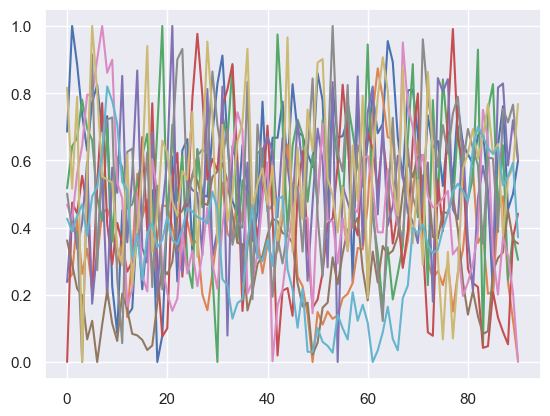

In [4]:
n_factors = 10
f = simulateRandomVar1(k=n_factors,T=100)
plt.plot(f);

# Decoder

In [5]:
n_obs = 100
dec = Decoder(hidden_dim=[n_factors, n_obs], activation=nn.Tanh())
f_tensor = torch.Tensor(f).float()
y = dec(f_tensor)

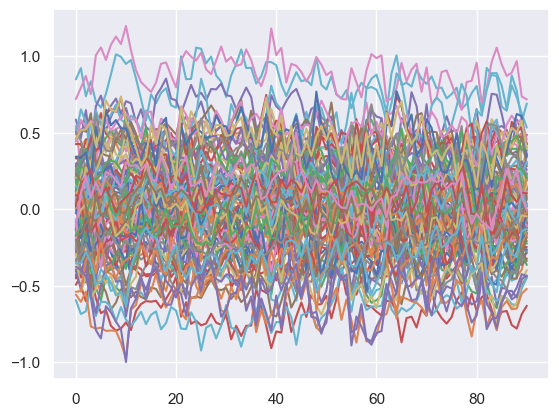

In [8]:
plt.plot(y.detach().numpy());

## Var(p)

In [6]:
"""
def simulateVar(coeff: list[np.ndarray], x0: list[np.ndarray], delta:np.ndarray, mu:np.ndarray, omega:np.ndarray, T=100):
    res = x0
    for t in range(T):
        xt = mu
        xt += np.random.multivariate_normal(mu,omega)
        for i, b in enumerate(coeff,1):
            xt += b @ res[-i]
    return res
"""

from statsmodels.tsa.vector_ar.var_model import VARProcess

def simulateVar(coeff: list[np.ndarray], omega:np.ndarray, T=100):
    coefs = np.stack(coeff, axis=0)
    print(coefs.shape)
    proc = VARProcess(coefs = coefs, coefs_exog = np.array([0]), sigma_u = omega)
    if not proc.is_stable(verbose=False):
        proc.is_stable(verbose=True)
        raise ValueError("Provided system is not stable")
    return proc.simulate_var(steps = T)#, initial_values=np.random.normal(size=omega.shape[0]))

In [50]:
k = 5
omega = np.identity((k))
p = 10
l = p
b = [np.eye(k)/(_+1) *np.random.uniform(size=(k,k)) for _ in range(1,p+1)]
f = simulateVar(b, omega, T=1000)
fig,axs = plt.subplots(nrows= f.shape[1], ncols= 1, figsize=(20,10))
for i in range(f.shape[1]):
    axs[i].plot(f[:,i])

(10, 5, 5)
Eigenvalues of VAR(1) rep
0.9542446054707578
0.7135472701234812
0.7135472701234812
0.7465591322472187
0.6555505105594353
0.6555505105594353
0.7172413524344864
0.7172413524344864
0.5014398120640927
0.5014398120640927
1.0651423988784885
0.7604697548197988
0.7604697548197988
0.7334520647326849
0.7334520647326849
0.7446464473219092
0.7446464473219092
0.6547186283023021
0.6547186283023021
0.5966364165276292
1.0124687727691106
0.8018100186768855
0.8018100186768855
0.7792970708761877
0.7792970708761877
0.7370590406475807
0.7399070323764276
0.7399070323764276
0.7251740044032515
0.7251740044032515
1.0110530683665122
0.8488279608199236
0.7536498720357762
0.7536498720357762
0.8060300986918899
0.8060300986918899
0.7061004536562379
0.7061004536562379
0.7445429178641233
0.7445429178641233
0.9933089288592466
0.8073124059393374
0.8073124059393374
0.7212897663753727
0.7774674536983484
0.7774674536983484
0.748380422919989
0.748380422919989
0.7144927052183433
0.7144927052183433


ValueError: Provided system is not stable

Decoder(
  (activation): Tanh()
  (sequential): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=50, bias=True)
  )
)
(101, 5)


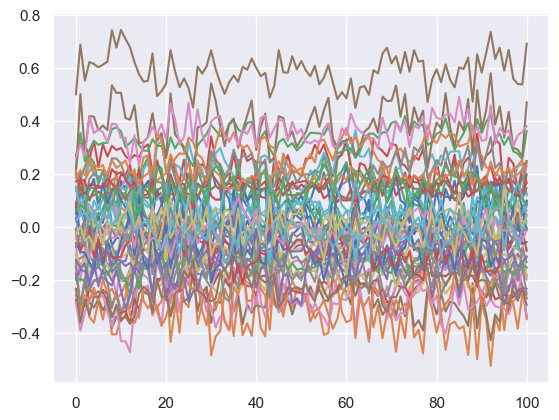

In [352]:
import dgp
dec = Decoder(hidden_dim=[n_factors, 20, n_obs], activation=nn.Tanh(), lastLayerLinear=False)
f, y = dgp.getSimulatedNonlinear(factor_dim=n_factors, obs_dim=100,T=100, dec=dec, activation = nn.Sigmoid())
print(f.shape)
plt.plot(y);

Obtained stable system after 22 iterations.
Decoder(
  (activation): Tanh()
  (sequential): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=50, bias=True)
  )
)
torch.Size([495, 5])


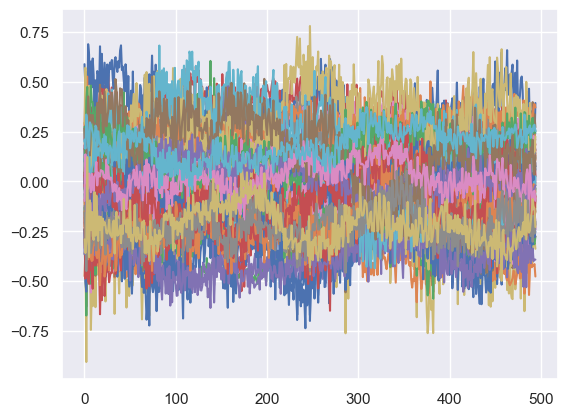

In [358]:
n_obs = 50
n_factors = 5
dec = Decoder(hidden_dim=[n_factors, 20, n_obs], activation=nn.Tanh(), lastLayerLinear=False)
f, y = dgp.getSimulatedNonlinearVarP(factor_dim=n_factors, obs_dim=n_obs,T=500, dec=dec)
plt.plot(y);

Obtained stable system after 22 iterations.
(600, 5)


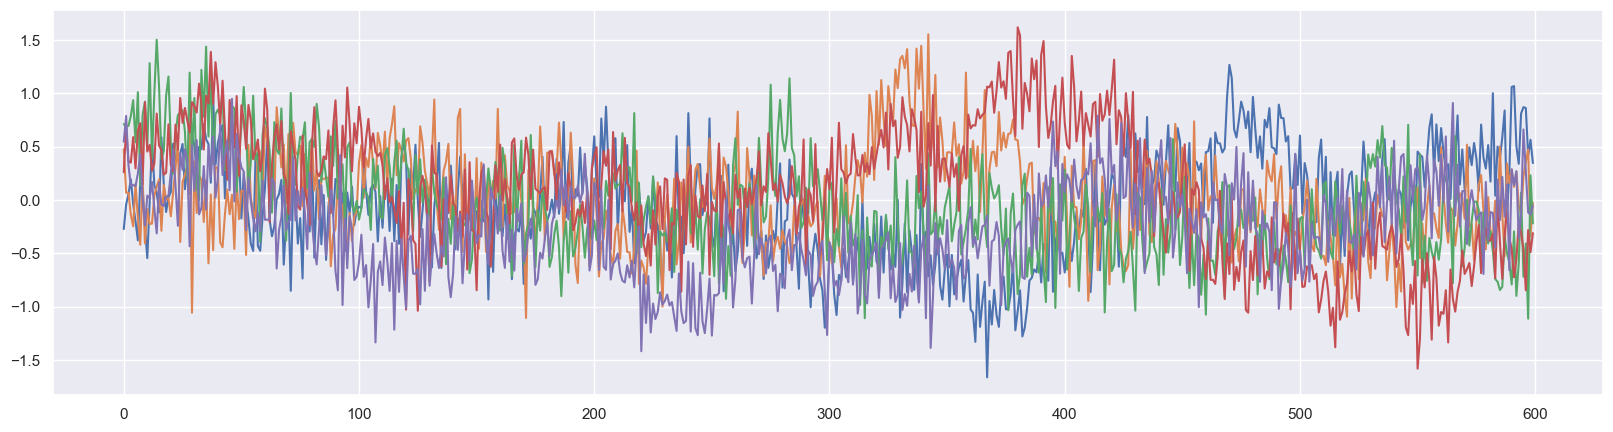

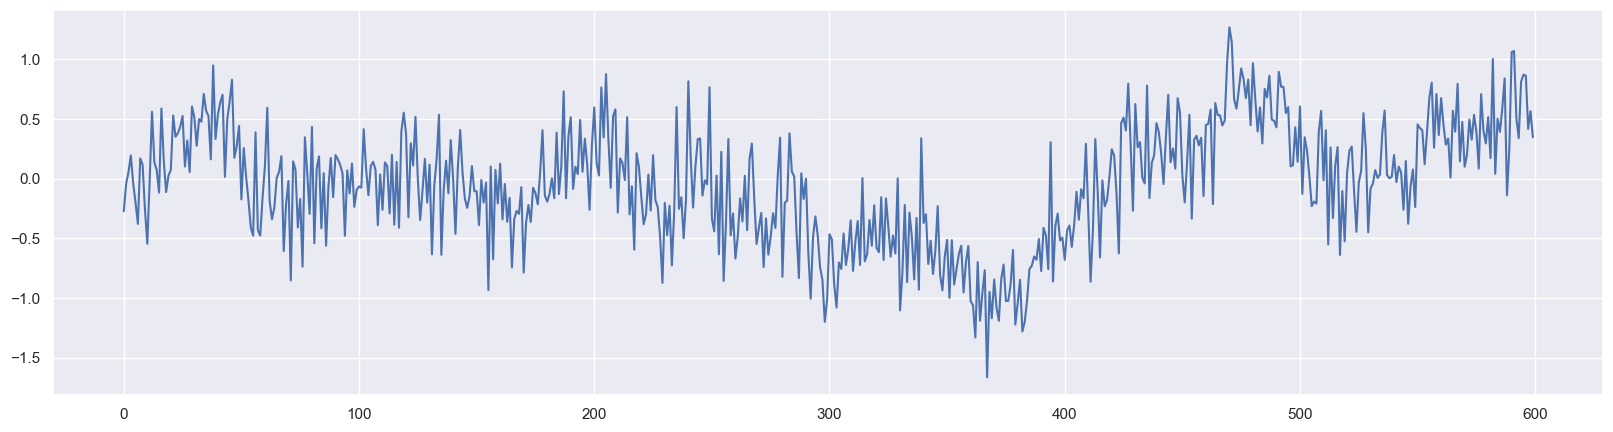

In [414]:
from dgp import simulateRandomVarP, getVarCoeffient
d = 5
p = 5
T = 600
sim = simulateRandomVarP(d,p,T, T_warmup=100, diagonal=True)
plt.figure(figsize=(20,5))
plt.plot(sim);
plt.figure(figsize=(20,5))
print(sim.shape)
plt.plot(sim[:,0]);

In [415]:
coefs, _ = getVarCoeffient(3,2,np.eye(2), diagonal=True)

Obtained stable system after 17 iterations.


In [416]:
coefs

array([[[0.65288741, 0.        , 0.        ],
        [0.        , 0.65288741, 0.        ],
        [0.        , 0.        , 0.65288741]],

       [[0.3264437 , 0.        , 0.        ],
        [0.        , 0.3264437 , 0.        ],
        [0.        , 0.        , 0.3264437 ]]])

<Axes: >

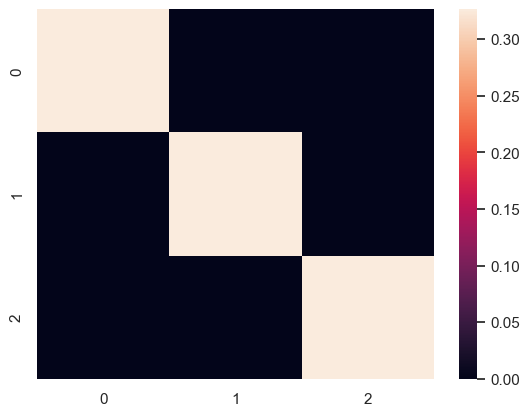

In [417]:
sns.heatmap(coefs[1])

In [285]:
init = np.random.normal(size=(3,2))
#init.shape
init
print(coefs.shape, init.shape)

(2, 3, 3) (3, 2)


In [277]:
np.tensordot(coefs.T, init)

array([ 0.68597968,  0.77591602, -0.53272907])

In [272]:
a = np.array([
    [[1,0],[0,1]],
    [[1,0],[0,1]]]
    )
b = np.array([
    [1,2],
    [2,1]
])
print(a.shape, b.shape)
np.tensordot(a,b)

array([2, 2])

In [252]:
np.sum(init * coefs,axis=0)                        

array([[ 1.69819146,  0.        ],
       [ 0.        , -0.20002397]])

In [245]:
np.sum(init * coefs,axis=1).shape

(5, 5)

In [334]:
coefs

array([[[0.33503447, 0.        , 0.        ],
        [0.        , 0.33503447, 0.        ],
        [0.        , 0.        , 0.33503447]],

       [[0.16751724, 0.        , 0.        ],
        [0.        , 0.16751724, 0.        ],
        [0.        , 0.        , 0.16751724]],

       [[0.11167816, 0.        , 0.        ],
        [0.        , 0.11167816, 0.        ],
        [0.        , 0.        , 0.11167816]],

       [[0.08375862, 0.        , 0.        ],
        [0.        , 0.08375862, 0.        ],
        [0.        , 0.        , 0.08375862]],

       [[0.06700689, 0.        , 0.        ],
        [0.        , 0.06700689, 0.        ],
        [0.        , 0.        , 0.06700689]],

       [[0.05583908, 0.        , 0.        ],
        [0.        , 0.05583908, 0.        ],
        [0.        , 0.        , 0.05583908]],

       [[0.04786207, 0.        , 0.        ],
        [0.        , 0.04786207, 0.        ],
        [0.        , 0.        , 0.04786207]],

       [[0.04187931,

Obtained stable system after 24 iterations.


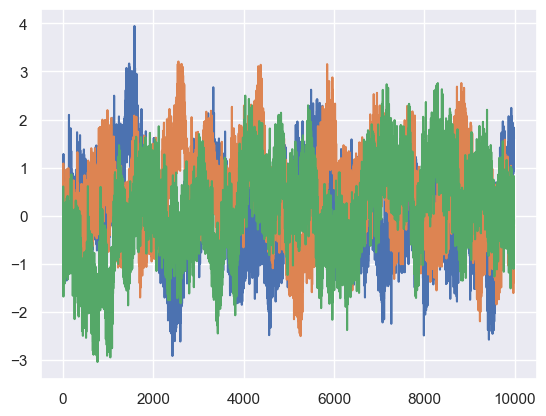

In [335]:
from dgp import simulateVarP
coefs
d=3
coefs, _ = getVarCoeffient(d=d,p=10)
plt.plot(simulateVarP(coefs,T=10000, covar = np.eye(d)/5).T)

In [329]:
%timeit -r 4 -n 100 simulateVarP(coefs,T=10000)
#%timeit -r 4 -n 100 varsim(coefs, intercept=np.zeros(3), sig_u = np.eye(3), steps=10000)

247 ms ± 4.27 ms per loop (mean ± std. dev. of 4 runs, 100 loops each)


In [325]:
from statsmodels.tsa.vector_ar.util import varsim
%timeit -r 4 -n 100 varsim(coefs, intercept=np.zeros(3), sig_u = np.eye(3), steps=10000)

238 ms ± 6.86 ms per loop (mean ± std. dev. of 4 runs, 100 loops each)


In [120]:

from statsmodels.tsa.vector_ar import util
util.varsim

<function statsmodels.tsa.vector_ar.util.varsim(coefs, intercept, sig_u, steps=100, initvalues=None, seed=None)>

<Axes: >

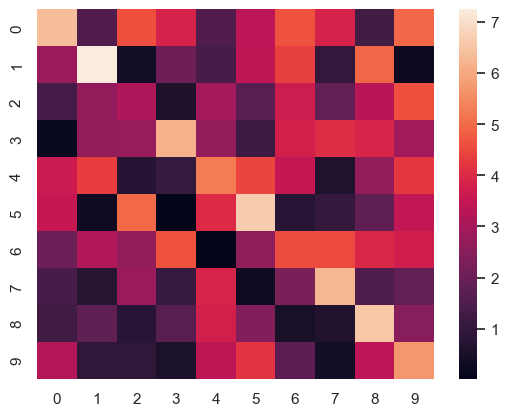

In [102]:
sns.heatmap(coeff[0])

In [53]:
np.eye(d)

NameError: name 'd' is not defined

In [224]:
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
print(y.shape)
mod = DynamicFactor(endog = y, k_factors=10, factor_order=4,error_order = 4)
#mod.fit()

(101, 100)


In [221]:
mod._params_factor_transition


slice(1100, 1500, None)

In [222]:
mod._params_factor_transition
mod.parameters['factor_transition']
mod.ssm['transition'].shape

(440, 440)

<Axes: >

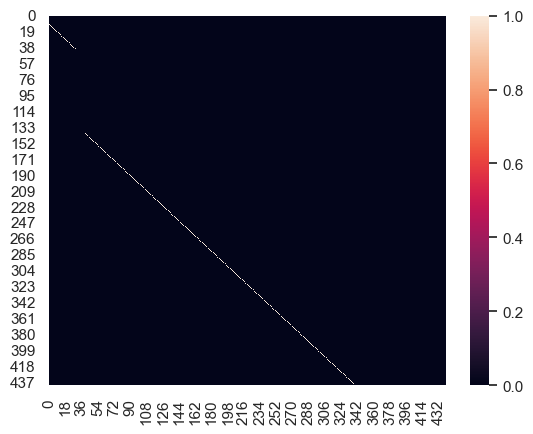

In [223]:
sns.heatmap(mod.ssm['transition'])

In [ ]:
 mod_factors = VAR(res_pca.factors)
res_factors = mod_factors.fit(maxlags=self.factor_order, ic=None,
                                trend='n')
# Save the parameters
params[self._params_factor_transition] = (
    res_factors.params.T.ravel())

# Test for stationarity
coefficient_matrices = (
    params[self._params_factor_transition].reshape(
        self.k_factors * self.factor_order, self.k_factors
    ).T
).reshape(self.k_factors, self.k_factors, self.factor_order).T

stationary = is_invertible([1] + list(-coefficient_matrices))